Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


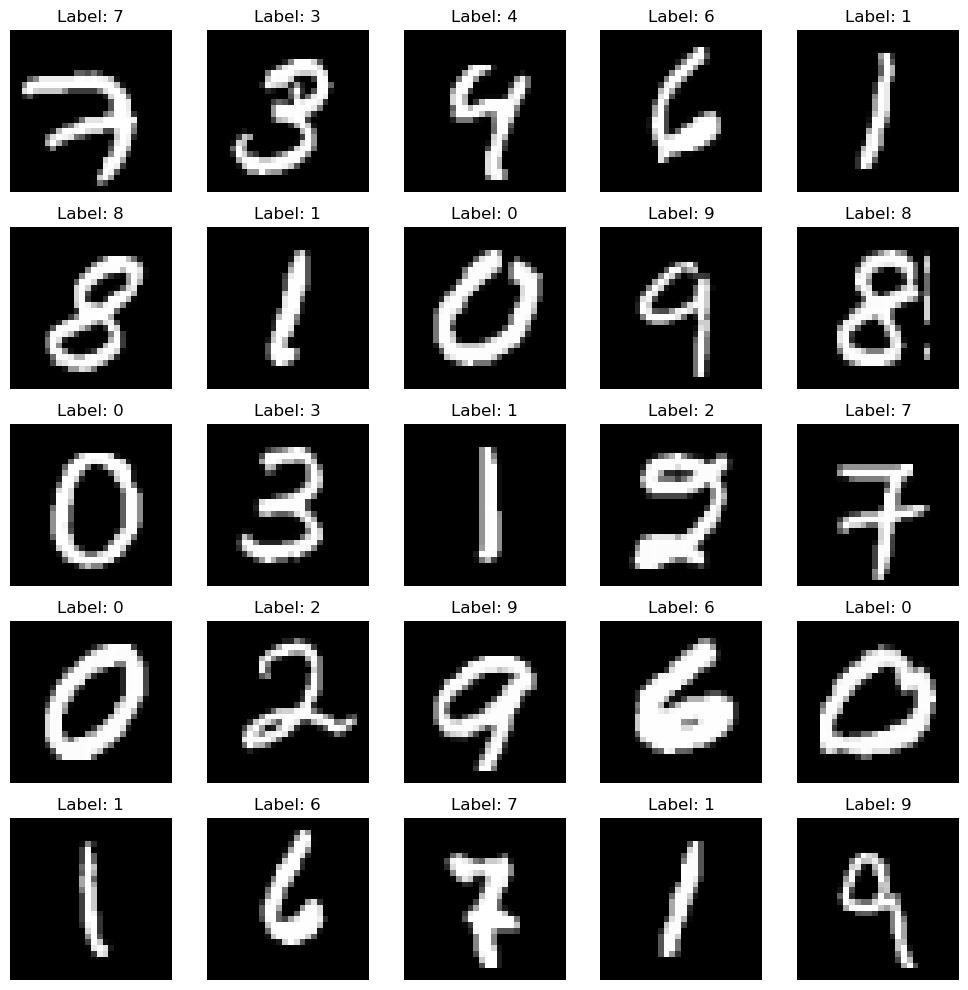

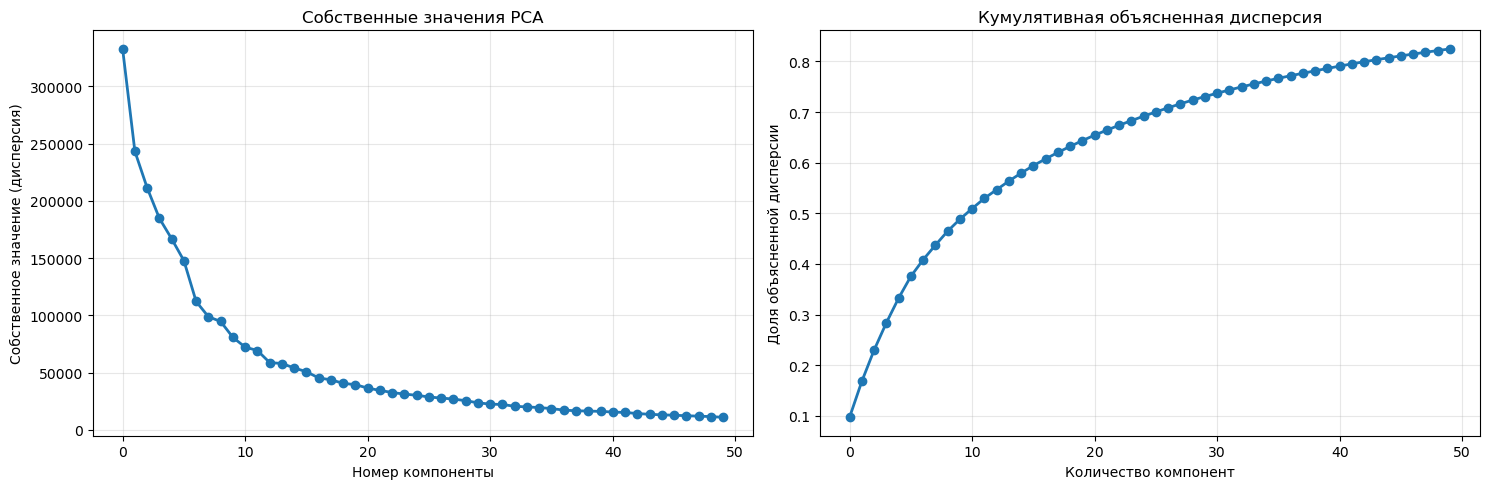

Первые 15 компонент покрывают 57.93% дисперсии
Первые 30 компонент покрывают 73.05% дисперсии
Первые 64 компонент покрывают 86.20% дисперсии


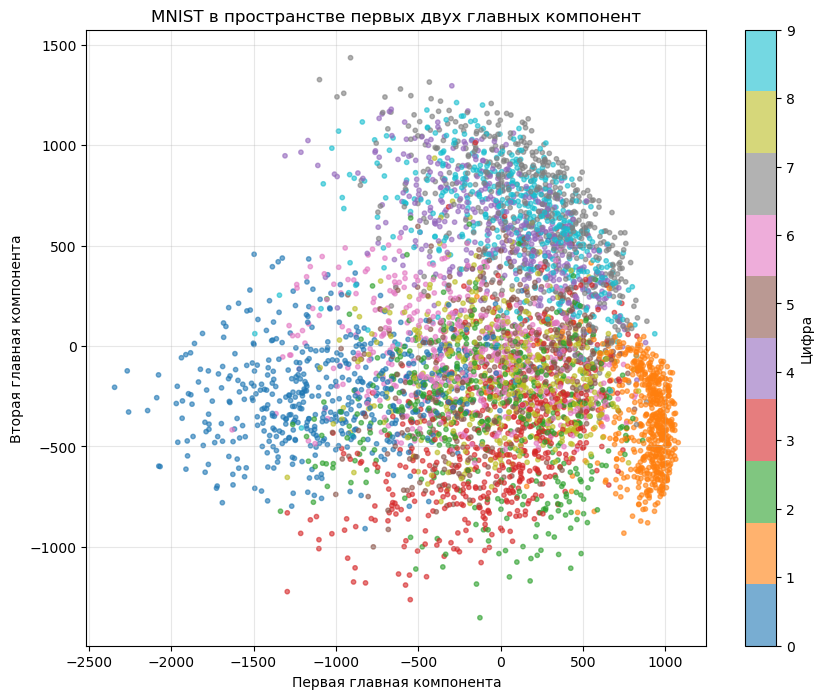


=== Базовый kNN на исходных данных ===
Точность kNN (k=5) на исходных данных: 0.2380

=== Поиск оптимальных параметров PCA + kNN ===
Компонент:  1, Соседей:  1, Точность: 0.2325
Компонент:  1, Соседей:  3, Точность: 0.2520
Компонент:  1, Соседей:  5, Точность: 0.2570
Компонент:  1, Соседей:  7, Точность: 0.2560
Компонент:  1, Соседей:  9, Точность: 0.2560
Компонент:  1, Соседей: 11, Точность: 0.2560
Компонент:  1, Соседей: 15, Точность: 0.2650
Компонент:  1, Соседей: 20, Точность: 0.2805
Компонент:  1, Соседей: 25, Точность: 0.2790
Компонент:  1, Соседей: 30, Точность: 0.2805
Компонент:  2, Соседей:  1, Точность: 0.3610
Компонент:  2, Соседей:  3, Точность: 0.3590
Компонент:  2, Соседей:  5, Точность: 0.3975
Компонент:  2, Соседей:  7, Точность: 0.4020
Компонент:  2, Соседей:  9, Точность: 0.4015
Компонент:  2, Соседей: 11, Точность: 0.4080
Компонент:  2, Соседей: 15, Точность: 0.4160
Компонент:  2, Соседей: 20, Точность: 0.4055
Компонент:  2, Соседей: 25, Точность: 0.4080
Компонент: 

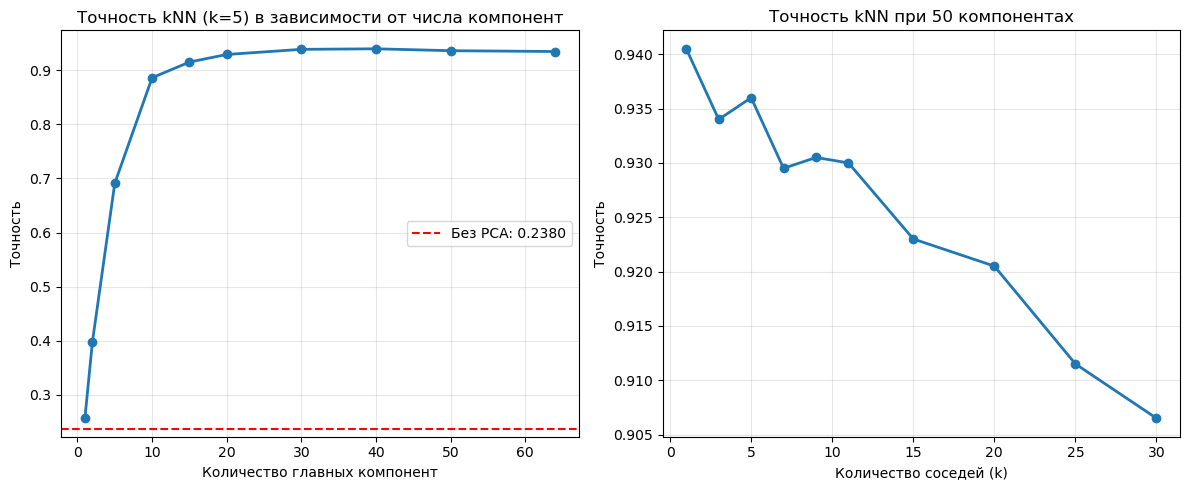


=== Лучшие параметры ===
Количество компонент: 50
Количество соседей: 1
Лучшая точность: 0.9405

=== Сравнение с sklearn (проверка) ===
Точность sklearn PCA+kNN: 0.9405
Точность нашей реализации: 0.9405
Разница: 0.000000

ВЫВОДЫ ПО РАБОТЕ:
1. PCA позволяет значительно сократить размерность данных:
   - 15 компонент сохраняют 57.9% дисперсии
   - 30 компонент сохраняют 73.1% дисперсии
   - 64 компонент сохраняют 86.2% дисперсии

2. Визуализация в 2D PCA показывает:
   - Цифры частично разделимы в пространстве главных компонент
   - Некоторые классы (например, 0 и 1) хорошо отделяются
   - Другие классы (например, 4 и 9) могут пересекаться

3. kNN на исходных данных (784 признака):
   - Точность: 0.2380

4. Оптимальные параметры PCA+kNN:
   - Компонент: 50
   - Соседей: 1
   - Точность: 0.9405

5. Наблюдения:
   - PCA может улучшить точность kNN за счет устранения шума
   - Слишком мало компонент теряет информацию, слишком много - добавляет шум
   - Оптимальное k зависит от данных и раз

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mnist import load_mnist

# 1. Загрузка и визуализация данных

# 1) Загрузка данных MNIST
train, validation, test = load_mnist()

# Объединяем train и validation для большего обучающего набора
X_train_full = np.concatenate([train[0], validation[0]], axis=0)
y_train_full = np.concatenate([train[1], validation[1]], axis=0)

X_test = test[0]
y_test = test[1]

# Преобразуем из формы (N, 28, 28, 1) в (N, 784)
X_train_full = X_train_full.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# 2) Визуализация нескольких примеров
def plot_mnist_samples(X, y, num_samples=25):
    """Визуализация нескольких примеров MNIST"""
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(num_samples):
        img = X[i].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Преобразуем one-hot обратно в обычные метки для визуализации
y_train_labels = np.argmax(y_train_full, axis=1) if y_train_full.ndim > 1 else y_train_full
plot_mnist_samples(X_train_full, y_train_labels)


# 2. Реализация PCA

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        """
        Шаг 1: Центрирование данных
        Шаг 2: Вычисление матрицы ковариации
        Шаг 3: Вычисление собственных векторов и значений
        """
        # Шаг 1: Центрирование
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Шаг 2: Вычисление матрицы ковариации
        # Для эффективности используем SVD вместо прямого вычисления ковариации
        # Ковариационная матрица = (X_centered.T @ X_centered) / (n-1)

        # Шаг 3: SVD разложение
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # Собственные векторы (главные компоненты)
        self.components = Vt.T

        # Собственные значения (дисперсия вдоль главных компонент)
        # S содержит сингулярные значения, собственные значения = S^2 / (n-1)
        n_samples = X.shape[0]
        self.explained_variance = (S ** 2) / (n_samples - 1)
        self.explained_variance_ratio = self.explained_variance / np.sum(self.explained_variance)

        # Если задано количество компонент, обрезаем
        if self.n_components is not None:
            self.components = self.components[:, :self.n_components]
            self.explained_variance = self.explained_variance[:self.n_components]
            self.explained_variance_ratio = self.explained_variance_ratio[:self.n_components]

        return self

    def transform(self, X):
        """Шаг 4: Преобразование данных в координаты главных компонент"""
        if self.mean is None or self.components is None:
            raise ValueError("PCA must be fitted before transform")

        X_centered = X - self.mean
        return X_centered @ self.components

    def fit_transform(self, X):
        """Объединение fit и transform"""
        self.fit(X)
        return self.transform(X)


# 3. Анализ PCA

# 1) Применение PCA ко всем данным
pca_full = my_PCA()
X_pca_full = pca_full.fit_transform(X_train_full)

# 2) График собственных значений
plt.figure(figsize=(15, 5))

# График собственных значений
plt.subplot(1, 2, 1)
plt.plot(pca_full.explained_variance[:50], 'o-', linewidth=2)
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение (дисперсия)')
plt.title('Собственные значения PCA')
plt.grid(True, alpha=0.3)

# График кумулятивной суммы объясненной дисперсии
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio)
plt.plot(cumulative_variance[:50], 'o-', linewidth=2)
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Кумулятивная объясненная дисперсия')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка: какую долю дисперсии покрывают первые 15 компонент?
print(f"Первые 15 компонент покрывают {cumulative_variance[14]*100:.2f}% дисперсии")
print(f"Первые 30 компонент покрывают {cumulative_variance[29]*100:.2f}% дисперсии")
print(f"Первые 64 компонент покрывают {cumulative_variance[63]*100:.2f}% дисперсии")

# 3) Визуализация данных в пространстве первых двух главных компонент
pca_2d = my_PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_full[:5000])  # Берем подмножество для визуализации
y_labels_2d = y_train_labels[:5000]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                     c=y_labels_2d, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Цифра')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('MNIST в пространстве первых двух главных компонент')
plt.grid(True, alpha=0.3)
plt.show()


# 4. Реализация kNN

class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Сохранение обучающих данных"""
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        """Предсказание классов для новых данных"""
        if self.X_train is None or self.y_train is None:
            raise ValueError("kNN must be fitted before predict")

        y_pred = []

        for x in X:
            # Вычисление расстояний до всех обучающих точек
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            # Находим индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем метки ближайших соседей
            nearest_labels = self.y_train[nearest_indices]

            # Находим наиболее частую метку (моду)
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            most_common_label = unique_labels[np.argmax(counts)]

            y_pred.append(most_common_label)

        return np.array(y_pred)


# 5. Эксперименты с kNN

# 1) Разделение данных
# Преобразуем one-hot в обычные метки для kNN
y_train_simple = np.argmax(y_train_full, axis=0)
y_test_simple = np.argmax(y_test, axis=0)

# Для ускорения вычислений возьмем подмножество
X_train_small = X_train_full[:10000]
y_train_small = y_train_full[:10000]

X_test_small = X_test[:2000]
y_test_small = y_test[:2000]

# 2) Базовый kNN на исходных данных
print("\n=== Базовый kNN на исходных данных ===")
knn_baseline = my_kNN(n_neighbors=5)
knn_baseline.fit(X_train_small, y_train_small)
y_pred_baseline = knn_baseline.predict(X_test_small)
accuracy_baseline = accuracy_score(y_test_small, y_pred_baseline)
print(f"Точность kNN (k=5) на исходных данных: {accuracy_baseline:.4f}")

# 3) kNN с PCA
print("\n=== Поиск оптимальных параметров PCA + kNN ===")

# Перебираем разные количества компонент
components_to_try = [1, 2, 5, 10, 15, 20, 30, 40, 50, 64]
neighbors_to_try = [1, 3, 5, 7, 9, 11, 15, 20, 25, 30]

results = np.zeros((len(components_to_try), len(neighbors_to_try)))

for i, n_components in enumerate(components_to_try):
    # Применяем PCA
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_small)
    X_test_pca = pca.transform(X_test_small)

    for j, n_neighbors in enumerate(neighbors_to_try):
        # Обучаем kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_small)
        y_pred = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test_small, y_pred)
        results[i, j] = accuracy

        print(f"Компонент: {n_components:2d}, Соседей: {n_neighbors:2d}, Точность: {accuracy:.4f}")

# 4) Визуализация результатов
plt.figure(figsize=(12, 5))

# График 1: Зависимость точности от количества компонент (при фиксированном k=5)
plt.subplot(1, 2, 1)
k_index = neighbors_to_try.index(5)  # Индекс для k=5
accuracies_for_k5 = results[:, k_index]
plt.plot(components_to_try, accuracies_for_k5, 'o-', linewidth=2)
plt.xlabel('Количество главных компонент')
plt.ylabel('Точность')
plt.title('Точность kNN (k=5) в зависимости от числа компонент')
plt.grid(True, alpha=0.3)
plt.axhline(y=accuracy_baseline, color='r', linestyle='--',
           label=f'Без PCA: {accuracy_baseline:.4f}')
plt.legend()

# График 2: Зависимость точности от количества соседей (при оптимальном числе компонент)
plt.subplot(1, 2, 2)
best_component_idx = np.unravel_index(np.argmax(results), results.shape)[0]
best_n_components = components_to_try[best_component_idx]
accuracies_for_best_comp = results[best_component_idx, :]
plt.plot(neighbors_to_try, accuracies_for_best_comp, 'o-', linewidth=2)
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.title(f'Точность kNN при {best_n_components} компонентах')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5) Находим лучшие параметры
best_idx = np.unravel_index(np.argmax(results), results.shape)
best_n_components = components_to_try[best_idx[0]]
best_n_neighbors = neighbors_to_try[best_idx[1]]
best_accuracy = results[best_idx]

print(f"\n=== Лучшие параметры ===")
print(f"Количество компонент: {best_n_components}")
print(f"Количество соседей: {best_n_neighbors}")
print(f"Лучшая точность: {best_accuracy:.4f}")

# 6) Сравнение с sklearn (для проверки)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

print("\n=== Сравнение с sklearn (проверка) ===")

# PCA от sklearn
pca_sklearn = PCA(n_components=best_n_components)
X_train_pca_sk = pca_sklearn.fit_transform(X_train_small)
X_test_pca_sk = pca_sklearn.transform(X_test_small)

# kNN от sklearn
knn_sklearn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_sklearn.fit(X_train_pca_sk, y_train_small)
y_pred_sklearn = knn_sklearn.predict(X_test_pca_sk)
accuracy_sklearn = accuracy_score(y_test_small, y_pred_sklearn)

print(f"Точность sklearn PCA+kNN: {accuracy_sklearn:.4f}")
print(f"Точность нашей реализации: {best_accuracy:.4f}")
print(f"Разница: {abs(accuracy_sklearn - best_accuracy):.6f}")


# Выводы
print("\n" + "="*50)
print("ВЫВОДЫ ПО РАБОТЕ:")
print("="*50)
print("1. PCA позволяет значительно сократить размерность данных:")
print(f"   - 15 компонент сохраняют {cumulative_variance[14]*100:.1f}% дисперсии")
print(f"   - 30 компонент сохраняют {cumulative_variance[29]*100:.1f}% дисперсии")
print(f"   - 64 компонент сохраняют {cumulative_variance[63]*100:.1f}% дисперсии")

print("\n2. Визуализация в 2D PCA показывает:")
print("   - Цифры частично разделимы в пространстве главных компонент")
print("   - Некоторые классы (например, 0 и 1) хорошо отделяются")
print("   - Другие классы (например, 4 и 9) могут пересекаться")

print("\n3. kNN на исходных данных (784 признака):")
print(f"   - Точность: {accuracy_baseline:.4f}")

print(f"\n4. Оптимальные параметры PCA+kNN:")
print(f"   - Компонент: {best_n_components}")
print(f"   - Соседей: {best_n_neighbors}")
print(f"   - Точность: {best_accuracy:.4f}")

print("\n5. Наблюдения:")
print("   - PCA может улучшить точность kNN за счет устранения шума")
print("   - Слишком мало компонент теряет информацию, слишком много - добавляет шум")
print("   - Оптимальное k зависит от данных и размерности")
print("   - Наша реализация дает результаты, близкие к sklearn")